In [1]:
# importing required packages

import re, collections
from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en') #load english language model
from spacy import displacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

np.random.seed(42)
%matplotlib inline

## Read Data

In [3]:
myDir = Path.cwd().parents[0]
dataFolder = myDir / 'data/asap-sas'
print(dataFolder)

C:\Users\Devanshi\Desktop\finalProject\data\asap-sas


In [4]:
gradeMap = {1: 10,
                2: 10,
                3: 10,
                4:10,
                5: 10,
                6: 10,
                7:10,
                8:10,
                9:10,
                10:8}

subjectMap = {1: 'Science',
            2: 'Science',
            3: 'English Language Arts',
            4: 'English Language Arts',
            5: 'Biology',
            6: 'Biology',
            7:'English',
            8:'English',
            9:'English',
            10:'Science'}

In [5]:

df = pd.read_csv(dataFolder/'train.tsv', sep='\t', header=0)  #read data into dataframe
df.drop('Score2', inplace=True, axis=1) #Score 2 is for inter-rate reliability only

df['subject'] = df['EssaySet'].map(subjectMap)
df['studentGrade'] = df['EssaySet'].map(gradeMap)

df = df[['Id','EssaySet','subject','studentGrade','EssayText','Score1']] #rearrange columns
df.head()



,Id,EssaySet,subject,studentGrade,EssayText,Score1
0,1,1,Science,10,Some additional information that we would need...,1
1,2,1,Science,10,"After reading the expirement, I realized that ...",1
2,3,1,Science,10,"What you need is more trials, a control set up...",1
3,4,1,Science,10,The student should list what rock is better an...,0
4,5,1,Science,10,For the students to be able to make a replicat...,2


In [16]:
df.isnull().sum() #no missing values

Id              0
EssaySet        0
subject         0
studentGrade    0
EssayText       0
EssayLength     0
dtype: int64

In [16]:
group_count = df.groupby(df.EssaySet).size().reset_index(name='essay_count')
group_count['EssaySet'] = group_count['EssaySet'].astype(str)
group_count

,EssaySet,essay_count
0,1,1672
1,2,1278
2,3,1891
3,4,1738
4,5,1795
5,6,1797
6,7,1799
7,8,1799
8,9,1798
9,10,1640


Text(0.5,1,'Essays per Set')

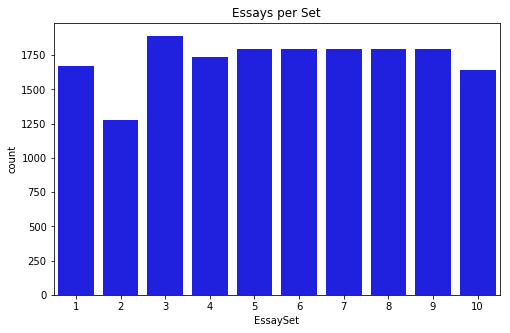

In [6]:
plt.figure(figsize=(8,5))
g = sns.countplot(x="EssaySet", color='b' ,data=df)
g.set_title("Essays per Set")

### Type of Response

1: Source Dependent
2: Source Dependent
3: Source Dependent
4: Source Dependent
5: Non Source
6: Non Source
7: Source Dependent
8: Source Dependent
9: Source Dependent
10: Source Dependent


Text(0.5,1,'Score Distribution per Essay Set')

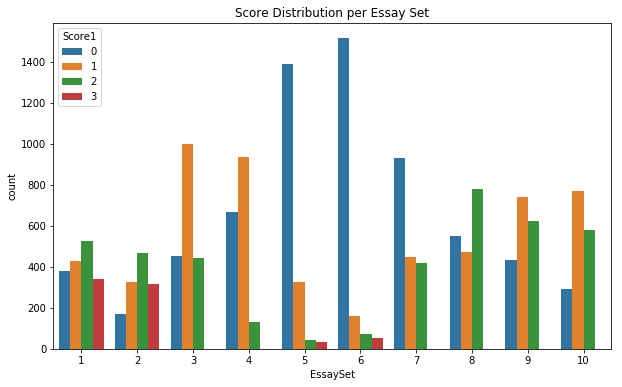

In [7]:
plt.figure(figsize=(10,6))
g = sns.countplot(x="EssaySet", hue="Score1",  data=df)
g.set_title("Score Distribution per Essay Set")

## Histogram of essay length across each Essay Set

In [8]:
df['EssayLength'] = df['EssayText'].apply(len)
df.head()

,Id,EssaySet,subject,studentGrade,EssayText,Score1,EssayLength
0,1,1,Science,10,Some additional information that we would need...,1,314
1,2,1,Science,10,"After reading the expirement, I realized that ...",1,296
2,3,1,Science,10,"What you need is more trials, a control set up...",1,169
3,4,1,Science,10,The student should list what rock is better an...,0,88
4,5,1,Science,10,For the students to be able to make a replicat...,2,158


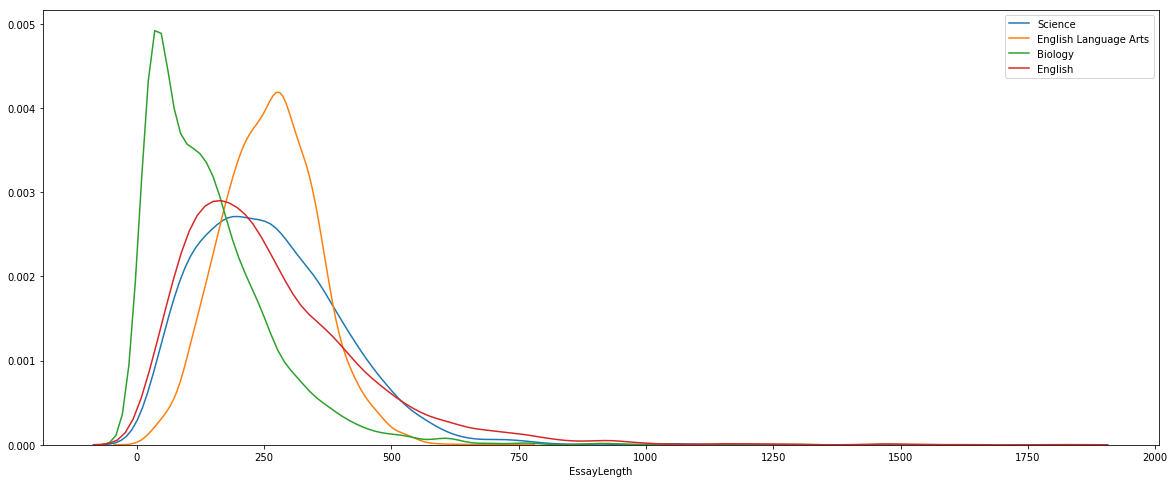

In [11]:
plt.figure(figsize=(20,8))
for i in df.subject.unique():
    
    mydf = df.loc[df.subject == i]
    sns.distplot(mydf['EssayLength'],hist=False, label= i)
    
plt.show()

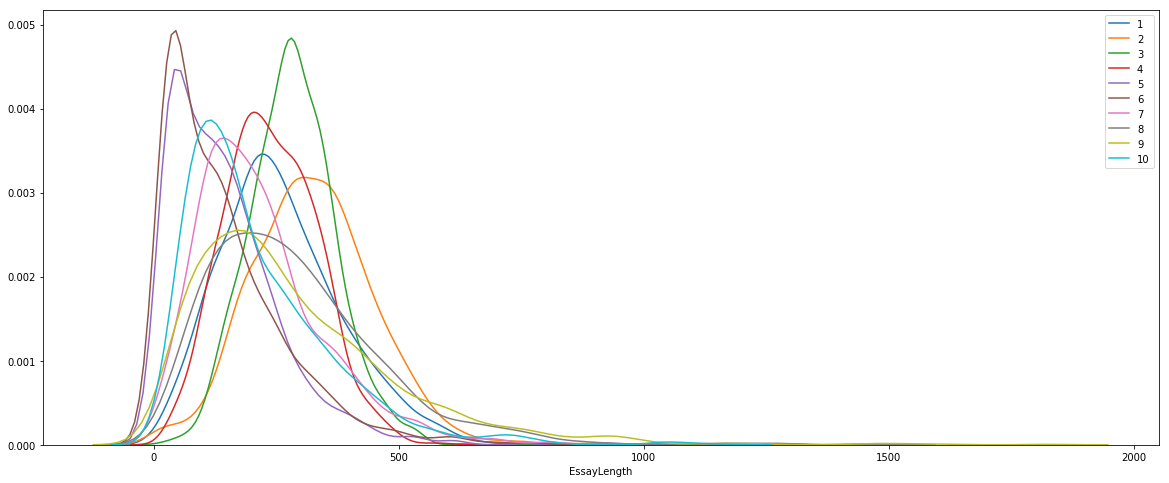

In [12]:
plt.figure(figsize=(20,8))
for i in df.EssaySet.unique():
    
    mydf = df.loc[df.EssaySet == i]
    sns.distplot(mydf['EssayLength'],hist=False, label=i)
    
plt.show()
# g.savefig("FinalGraphs/kdeplot.png", dpi=300, bbox_inches='tight')

<Figure size 1440x504 with 0 Axes>

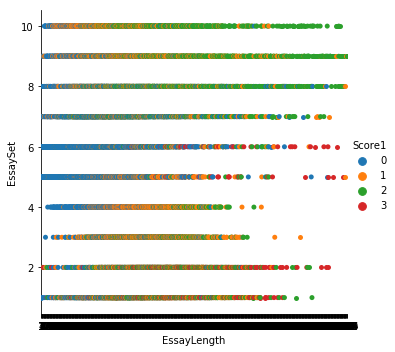

In [36]:
plt.figure(figsize=(20,7))
sns.catplot(x="EssayLength", y="EssaySet",kind="swarm", hue="Score1", data=df)
# sns.despine(left=True)

### Split Data 
* into X & y 
* train & test set

In [13]:
print(df.shape)

y = df.Score1
X = df
X.drop('Score1', axis=1, inplace = True)

(17207, 7)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Text Preprocessing

#### 1) Tokenisation

In [27]:
nlp = spacy.load('en')

In [15]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple PROPN nsubj
is VERB aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN compound
startup NOUN dobj
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [21]:
tem_df = X_train.head().copy()

In [22]:
tokens = []
lemma = []
pos = []

for doc in nlp.pipe(tem_df['EssayText'], batch_size=50, n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

tem_df['species_tokens'] = tokens
tem_df['species_lemma'] = lemma
tem_df['species_pos'] = pos

In [23]:
tem_df.head()

,Id,EssaySet,subject,studentGrade,EssayText,EssayLength,species_tokens,species_lemma,species_pos
582,583,1,Science,10,To replicate the experiment you might need to ...,87,"[To, replicate, the, experiment, you, might, n...","[to, replicate, the, experiment, -PRON-, may, ...","[PART, VERB, DET, NOUN, PRON, VERB, VERB, PART..."
10063,15648,6,Biology,10,One form of getting around ould be using a fla...,453,"[One, form, of, getting, around, ould, be, usi...","[one, form, of, get, around, ould, be, use, a,...","[NUM, NOUN, ADP, VERB, PART, ADV, VERB, VERB, ..."
15584,25966,10,Science,8,black :: it will keep the inside of the dog ho...,57,"[black, :, :, it, will, keep, the, inside, of,...","[black, :, :, -PRON-, will, keep, the, inside,...","[ADJ, PUNCT, PUNCT, PRON, VERB, VERB, DET, NOU..."
14873,24056,9,English,10,The author gives you details like over the pas...,287,"[The, author, gives, you, details, like, over,...","[the, author, give, -PRON-, detail, like, over...","[DET, NOUN, VERB, PRON, NOUN, ADP, ADP, DET, A..."
5032,8261,4,English Language Arts,10,The significance of the word Invasive to the r...,195,"[The, significance, of, the, word, Invasive, t...","[the, significance, of, the, word, invasive, t...","[DET, NOUN, ADP, DET, NOUN, PROPN, ADP, DET, N..."


In [40]:
doc = nlp(tem_df['EssayText'].iloc[4])
doc.user_data['title'] = 'This is a title'
sentence_spans = list(doc.sents)

options = {'compact': True}
#displacy.render(doc, style='dep', jupyter=True)#options={'distance':140}

#Long texts can be visualised sentence by sentence
displacy.render(sentence_spans, style='dep', jupyter=True, options=options)


# colors = {'ORG': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)'}
# options = {'ents': ['ORG'], 'colors': colors}
# displacy.serve(doc, style='ent', options=options)




# svg = displacy.render(doc, style='dep')
# file_name = '-'.join([w.text for w in doc if not w.is_punct]) + '.svg'
# output_path = Path('/images/' + file_name)
# output_path.open('w', encoding='utf-8').write(svg)